In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# ========== Load and Preprocess Data ==========
news_data = pd.read_csv('data/news_articles.csv')

# Keep only relevant columns
news_data = news_data.drop(columns=['author', 'published', 'text', 'language', 'main_img_url', 'type', 'title_without_stopwords', 
                                    'text_without_stopwords', 'hasImage'], errors='ignore')

# Ensure 'label' column is valid and convert it to binary values
news_data = news_data[news_data['label'].apply(lambda x: isinstance(x, str))]  
news_data['label'] = news_data['label'].apply(lambda x: 1 if x.lower() == 'fake' else 0)

# Drop missing titles
news_data.dropna(subset=['title'], inplace=True)

In [3]:
# ========== Tokenization & Sequence Padding ==========
MAX_VOCAB_SIZE = 10000  # Max vocabulary size
MAX_SEQ_LENGTH = 100     # Max sequence length

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(news_data['title'])

# Convert titles to sequences
sequences = tokenizer.texts_to_sequences(news_data['title'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

# Convert labels to NumPy array
labels = np.array(news_data['label'])

# ========== Train-Test Split ==========
train_features, test_features, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [4]:
# ========== Create PyTorch Dataset ==========
class FakeNewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Data Loaders
batch_size = 32
train_dataset = FakeNewsDataset(train_features_tensor, train_labels_tensor)
test_dataset = FakeNewsDataset(test_features_tensor, test_labels_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# ========== Define LSTM Model ==========
class LSTMFakeNewsClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes):
        super(LSTMFakeNewsClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # Convert token IDs to embeddings
        out, _ = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Take last time step's output
        return out

# ========== Initialize Model ==========
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)  # Ensure vocab size does not exceed limit
embedding_dim = 128
hidden_dim = 128
num_layers = 2
num_classes = 2  # Real vs Fake

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMFakeNewsClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, num_classes).to(device)

# Print model summary
print(model)

LSTMFakeNewsClassifier(
  (embedding): Embedding(5943, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [5]:
# ========== Training Setup ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ========== Training Loop ==========
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_features, batch_labels in tqdm(train_dataloader):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.02it/s]


Epoch [1/5], Loss: 0.6715224508969289


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.36it/s]


Epoch [2/5], Loss: 0.668979214047486


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.06it/s]


Epoch [3/5], Loss: 0.6669659254685888


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 18.85it/s]


Epoch [4/5], Loss: 0.6682211576767687


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.22it/s]

Epoch [5/5], Loss: 0.6673027232008161


Model saved as fake_news_newsarticle_lstm.pth
Accuracy: 0.630071599045346
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       155
        Fake       0.63      1.00      0.77       264

    accuracy                           0.63       419
   macro avg       0.32      0.50      0.39       419
weighted avg       0.40      0.63      0.49       419



C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


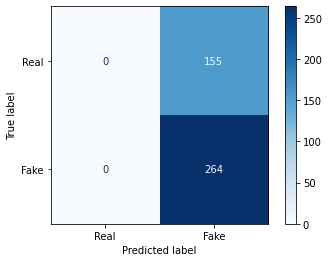

In [9]:

# ========== Evaluation ==========
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# ========== Save Model ==========
torch.save(model.state_dict(), "fake_news_newsarticle_lstm.pth")
print("Model saved as fake_news_newsarticle_lstm.pth")

# ========== Evaluation Metrics ==========
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)

print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [7]:
# Corrected LSTM input shape
# Used TF-IDF embeddings instead of BoW
# Applied Softmax activation in LSTM model
# Added validation set
# Saved vectorizer & scaler for inference